### Data Loader log analyser
Text report
- Responses count
- Unique entities count
- Avg. response time
- Stats by response code (requests count and avg. response time)
- Stats by process

Drawing charts
- Requests per time
- Avg. response time
- Response time by status code

In [355]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [356]:
load_dotenv()
reports_folder = os.environ.get('REPORTS_FOLDER')

#### Edit log file name below

In [375]:
report_file = "20230429_214023.log"

groupby_type = "MINUTES" # SECONDS

In [358]:
# Reading data from file
# Filtering lines in wrong format
file = open(reports_folder + report_file, 'r')

data = []
skipped_rows = 0
while file:
    line = file.readline()
    if line == "":
        break
        
    values = line.strip().split(";")
    if len(values) != 6:
        skipped_rows += 1
    else:
        data.append(values)
        
print("Log parsing results:")
print(f"- Lines loaded {len(data)}")
print(f"- Rows skipped {skipped_rows}")

Log parsing results:
- Lines loaded 66095
- Rows skipped 14


In [380]:
# Preparing data
# Converting formats
# Droping unnecessary cols

df_log = pd.DataFrame(data, columns=["Date", "Level", "Process", "Entity", "Code", "Response"])
df_warnings = df_log[df_log["Level"] == 'WARNING']
df_errors = df_log[df_log["Level"] == 'ERRORS']

df_log['Date'] = pd.to_datetime(df_log['Date'])
str_format = "%H:%M" if groupby_type == "MINUTES" else "%H:%M:%S" 
df_log['Time'] = df_log['Date'].dt.strftime(str_format)
    
# df_log['Code'] = df_log['Code'].astype(int)
df_log['Response'] = pd.to_timedelta(df_log['Response'])
df_log['Response time'] = df_log['Response'].dt.total_seconds()

df_log.drop(['Level', 'Date', 'Response'], axis=1, inplace=True)

print("Data sample")
print(tabulate(df_log.head(10), headers=["Process", "Entity", "Code", "Time", "Response time"], showindex=False))

Data sample
Process      Entity                                        Code  Time      Response time
-----------  ------------------------------------------  ------  ------  ---------------
receiver-1   0xc3986ac1e3c682f734c687c899d73da7e0524ad8     200  21:40          0.207092
receiver-3   0x3a03f68b9aab8d4aa68896cdf8583189206678dc     200  21:40          0.191072
receiver-0   0xdca4b5f0eaba1f2eaae3aafb13e3836d6441e0a7     200  21:40          0.212171
receiver-2   0xa61301a5199671ab6c5d2e21c718fddbdab778e3     200  21:40          0.186584
receiver-5   0x54a1f9674daaad0c61b346bf4018f4dd60390363     200  21:40          0.182563
receiver-11  0x3eb72125ff02a0e1e6276b66f0832835f4fc9337     200  21:40          0.225864
receiver-4   0x778cb94a215518266448d7ae81bd4a734a7efc92     200  21:40          0.229616
receiver-7   0xec9ff02779c0580c757483a82f26729068f4f710     200  21:40          0.231252
receiver-1   0x24bbbb243766a7ddc71244bdb45e1b0865111252     200  21:40          0.20606
receiver-6

In [365]:
# Preparing text report
print(f"Text report:\n")

# Responses count
responses_count = len(df_log.index)
print(f"1. Responses count: {responses_count}\n")

# Unique entities
unique_entities_count = len(pd.unique(df_log['Entity']))
print(f"2. Unique entities count: {unique_entities_count}\n")

# Avg response time
avg_response_time = df_log['Response time'].mean()
print(f"3. Avg. response time: {round(avg_response_time, 4)}s.\n")

# Stats by code
responses_by_code = (df_log.groupby("Code").agg(
                                            Count=('Entity', 'count'), 
                                            AvgResponseTime=('Response time', 'mean')))

responses_by_code = responses_by_code.reset_index().sort_values("Count", ascending=False)

print("4. Stats by response code\n")
_headers = ['Status code', "Requests count", "Avg. response time"]
print(tabulate(responses_by_code, headers=_headers, showindex=False))
print("\n")

# Avg response time by code
print("5. Stats by process\n")
responses_by_process = (df_log.groupby(["Process"]).agg(
                                            Count=('Entity', 'count'), 
                                            AvgResponseTime=('Response time', 'mean')))
responses_by_process = responses_by_process.reset_index()
responses_by_process = responses_by_process.sort_values("Count", ascending=False)
_headers = ['Process', 'Requests count', 'Avg. responce time']
print(tabulate(responses_by_process, headers=_headers, showindex=False))

Text report:

1. Responses count: 66095

2. Unique entities count: 66095

3. Avg. response time: 0.2315s.

4. Stats by response code

  Status code    Requests count    Avg. response time
-------------  ----------------  --------------------
          200             66081              0.228359
          504                14             15.1706


5. Stats by process

Process        Requests count    Avg. responce time
-----------  ----------------  --------------------
receiver-18              4012              0.225658
receiver-1               4000              0.226763
receiver-16              3998              0.225517
receiver-13              3990              0.22657
receiver-6               3990              0.226557
receiver-15              3952              0.229587
receiver-8               3918              0.230277
receiver-2               3915              0.231013
receiver-10              3912              0.232309
receiver-11              3901              0.233198
receiv

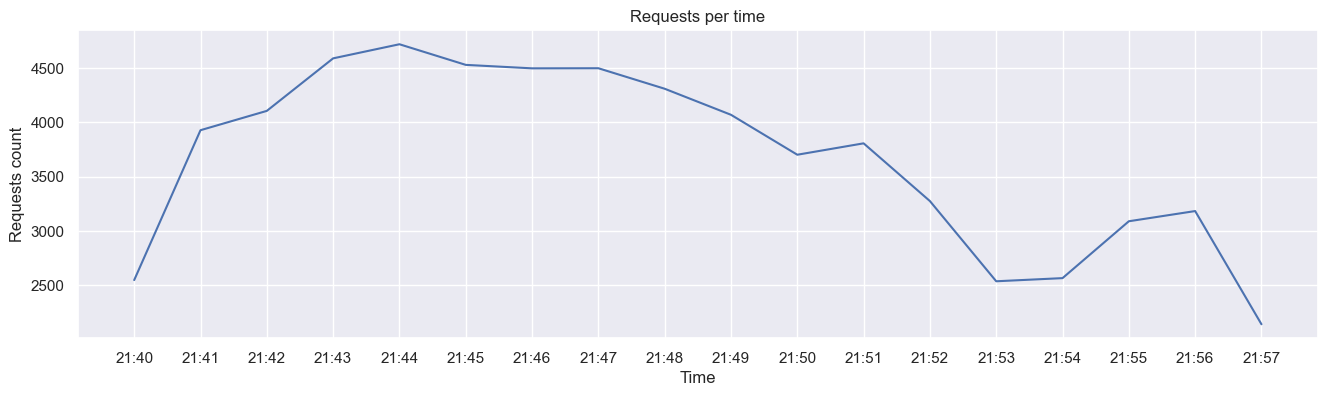

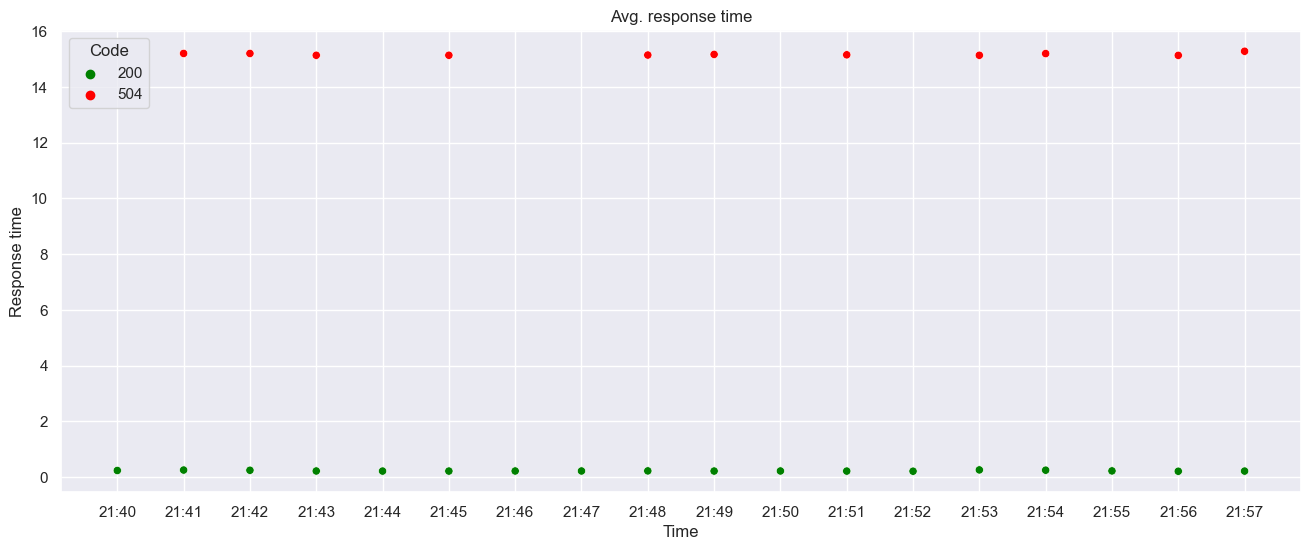

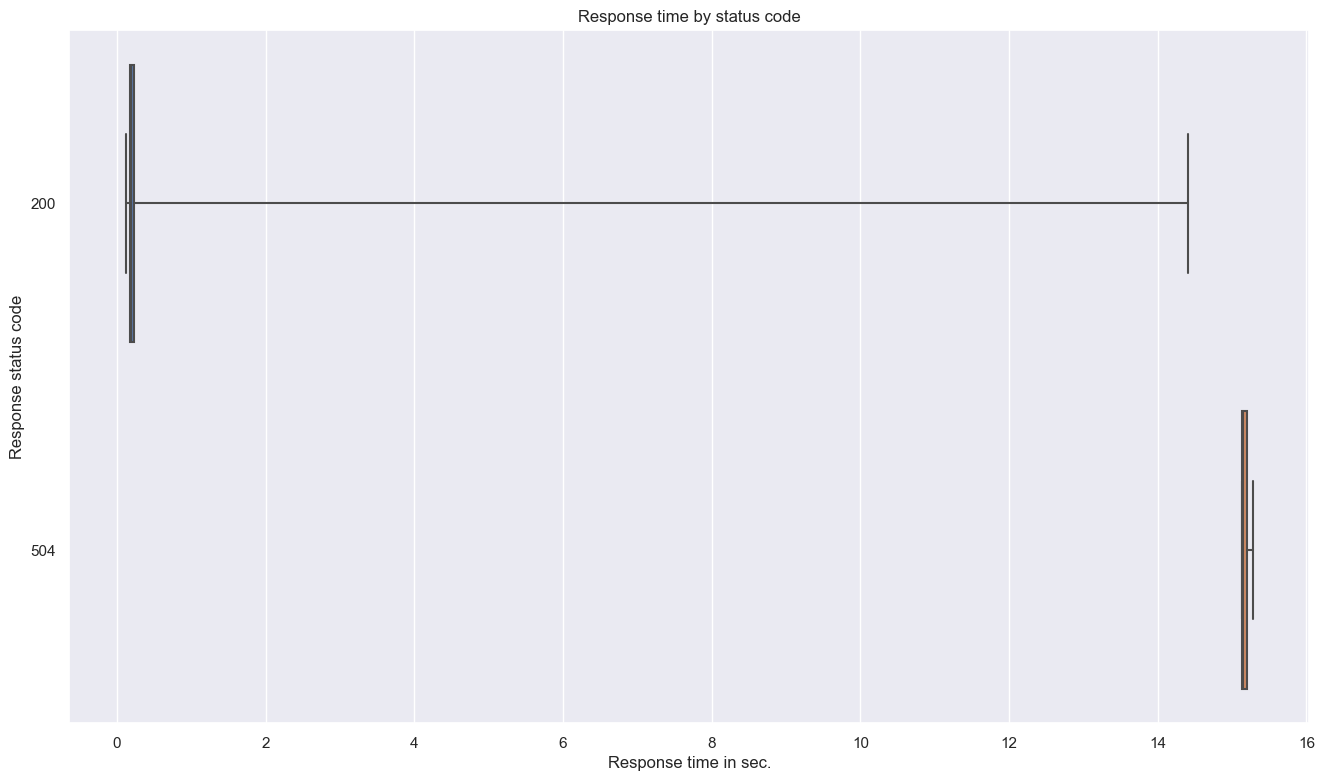

In [394]:
df_requests = df_log.groupby('Time').agg("Entity").count()

# Building request per time plot
plt.figure(figsize=(16, 4))
sns.set_theme()
plot = sns.lineplot(data=df_requests, markers=True)
plot.set(title='Requests per time', ylabel='Requests count')
plt.show()

# Building avg response time plot
plt.figure(figsize=(16, 6))
sns.set_theme()

df_requests_type = df_log.groupby(['Time', 'Code']).agg({"Entity": "count", "Response time": "mean"}).reset_index()
palette=['green','red'] #, 'orange','brown','dodgerblue']
plot_all = sns.scatterplot(data=df_requests_type, x="Time", y="Response time", hue="Code", palette=palette)
plot_all.set(title='Avg. response time')
plt.show()

# Preparing response time by status code plot
plt.figure(figsize=(16, 9))
sns.set_theme()

df_box = df_log
df_box['Code'] = df_box['Code'].astype(int)
plot = sns.boxplot(data=df_log, y="Code", x="Response time", whis=[0, 100], orient="h")
plot.set(title='Response time by status code', ylabel="Response status code", xlabel="Response time in sec.")

plt.show()

In [363]:
# Top slowest responses
limit = 20

df_log = df_log.sort_values('Response time', ascending=False)
sample = df_log.iloc[0:limit]

sample.reset_index(inplace=True, drop=True)

_headers = ['Process', 'Entity', 'Code', 'Time', 'Request time']
print(tabulate(sample, headers=_headers))

    Process      Entity                                        Code  Time        Request time
--  -----------  ------------------------------------------  ------  --------  --------------
 0  receiver-8   0x1062a747393198f70f71ec65a582423dba7e5ab3     504  21:57:24        15.2807
 1  receiver-7   0x96fa6acfc5f683db191234c74d315e5d732b07c0     504  21:54:26        15.2417
 2  receiver-9   0x7035ddda96657834e5f096026232d3ac7c2613ab     504  21:41:22        15.2021
 3  receiver-4   0x740d5718a79a8559feee8b00922f8cd773a81d84     504  21:42:22        15.2014
 4  receiver-19  0xd99e689d41afde916aafd566765f85edad09fd92     504  21:49:42        15.1863
 5  receiver-15  0xb1f1c46ecec6748c1f1e6d6bccff1fc9417318c0     504  21:51:02        15.153
 6  receiver-2   0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3     504  21:54:52        15.1523
 7  receiver-9   0x657439ed989b0ec28a09b592fda8c61ebd434b6a     504  21:49:00        15.1491
 8  receiver-10  0x33da80ce59602c2d66da944392cdf95bd4928c5e     504  

In [383]:
#### Take a look on warnings and errors
print(df_warnings)
# df_warnings.to_csv("./warnings.csv", sep=";")
print(df_errors)

                                  Date    Level      Process   
6066   2023-04-29T21:41:52.504074+0200  WARNING  receiver-10  \
7929   2023-04-29T21:42:22.472336+0200  WARNING   receiver-6   
8513   2023-04-29T21:42:31.650322+0200  WARNING  receiver-15   
8597   2023-04-29T21:42:32.965788+0200  WARNING   receiver-8   
10024  2023-04-29T21:42:52.621702+0200  WARNING   receiver-1   
10025  2023-04-29T21:42:52.633336+0200  WARNING   receiver-4   
10026  2023-04-29T21:42:52.636172+0200  WARNING  receiver-10   
10032  2023-04-29T21:42:52.679432+0200  WARNING  receiver-14   
10036  2023-04-29T21:42:52.721114+0200  WARNING  receiver-11   
11116  2023-04-29T21:43:07.772823+0200  WARNING   receiver-4   
11779  2023-04-29T21:43:17.450244+0200  WARNING  receiver-10   
14656  2023-04-29T21:43:54.045637+0200  WARNING   receiver-2   
16494  2023-04-29T21:44:16.445045+0200  WARNING  receiver-12   
16826  2023-04-29T21:44:20.711024+0200  WARNING  receiver-11   
17933  2023-04-29T21:44:35.066685+0200  